In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Concatenate, Flatten, BatchNormalization
from keras.losses import binary_crossentropy, mse

Using TensorFlow backend.


# mount ggdrive loading test_df

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My Drive/Mr.Dat/

/content/drive/My Drive/Mr.Dat


In [0]:
test_df = pd.read_csv('data/test_df.csv')

In [0]:
test_indices = test_df.index.values

In [0]:
cat_cols = ['assetCode']
num_cols = [c for c in test_df.columns if c not in ['assetCode', 'time', 'returnsOpenNextMktres10',
                                                         'date', 'binaray_return_next10days']] 

In [0]:
def encode(encoder, x):
    len_encoder = len(encoder)
    try:
        id = encoder[x]
    except KeyError:
        id = len_encoder
    return id

In [0]:
encoders = [{} for cat in cat_cols]

for i, cat in enumerate(cat_cols):
    print('encoding %s ...' % cat, end=' ')
    encoders[i] = {l: id for id, l in enumerate(test_df.loc[test_indices, cat].astype(str).unique())}
    test_df[cat] = test_df[cat].astype(str).apply(lambda x: encode(encoders[i], x))
    print('Done')

encoding assetCode ... Done


In [0]:
embed_sizes = [len(encoder) + 1 for encoder in encoders] #+1 for possible unknown assets

In [0]:
from sklearn.preprocessing import StandardScaler
 
test_df[num_cols] = test_df[num_cols].fillna(0)
print('scaling numerical columns')

scaler = StandardScaler()

scaler = StandardScaler()
test_df[num_cols] = scaler.fit_transform(test_df[num_cols])

scaling numerical columns


In [0]:
categorical_inputs = []
for cat in cat_cols:
    categorical_inputs.append(Input(shape=[1], name=cat))

categorical_embeddings = []
for i, cat in enumerate(cat_cols):
    categorical_embeddings.append(Embedding(embed_sizes[i], 10)(categorical_inputs[i]))

In [0]:
def get_input_NN(market_train, indices):
    X_num = market_train.loc[indices, num_cols].values
    X = {'num':X_num}
    for cat in cat_cols:
        X[cat] = market_train.loc[indices, cat_cols].values
    y = (market_train.loc[indices,'returnsOpenNextMktres10'] >= 0).values
    r = market_train.loc[indices,'returnsOpenNextMktres10'].values
    d = market_train.loc[indices, 'time'].dt.date
    return X,y,r,d

In [0]:
test_df['time'] = pd.to_datetime(test_df['time'], errors='coerce')

In [0]:
X_test,y_test,r_test,d_test = get_input_NN(test_df, test_indices)

In [0]:
from keras.models import load_model
from sklearn.metrics import accuracy_score

#  NN  result

In [0]:
nn_model = load_model("models/nn_model.hdf5")


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




0.5300952329111481


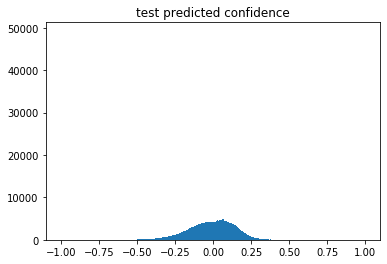

In [0]:
# distribution of confidence that will be used as submission
confidence_test_nn= nn_model.predict(X_test)[:,0]*2 -1
print(accuracy_score(confidence_test_nn>0,y_test))
plt.hist(confidence_test_nn, bins='auto')
plt.title("test predicted confidence")
plt.show()

In [0]:
# calculation of actual metric that is used to calculate final score
r_test = r_test.clip(-1,1) # get rid of outliers. Where do they come from??
x_t_i = confidence_test_nn * r_test
data = {'day' : d_test, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
std = np.std(x_t)
score_test = mean / std
print(score_test)

0.33616488306038644


# get input for lgb

In [0]:
test_df = pd.read_csv('data/test_df.csv')

In [0]:
def get_input_lgb(df):
    X = df[num_cols].values
    y = df.binaray_return_next10days.values
    r = df.returnsOpenNextMktres10.values
    d = df.time.dt.date
    return X,y,r,d

In [0]:
test_df['time'] = pd.to_datetime(test_df['time'], errors='coerce')
X_test,y_test,r_test,d_test = get_input_lgb(test_df)

In [0]:
import lightgbm as lgb

In [0]:
lgb1 = lgb.Booster(model_file='models/lgb1.txt')
lgb2 = lgb.Booster(model_file='models/lgb2.txt')

# lgb1  reslut

0.5845553941811182


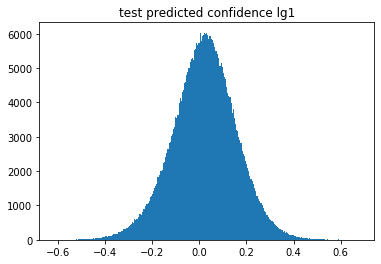

In [0]:
# distribution of confidence that will be used as submission
confidence_test_lgb1= lgb1.predict(X_test)*2 -1
print(accuracy_score(confidence_test_lgb1>0,y_test))
plt.hist(confidence_test_lgb1, bins='auto')
plt.title("test predicted confidence lg1")
plt.show()

In [0]:
# calculation of actual metric that is used to calculate final score
r_test = r_test.clip(-1,1) # get rid of outliers. Where do they come from??
x_t_i = confidence_test_lgb1 * r_test
data = {'day' : d_test, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
std = np.std(x_t)
score_test = mean / std
print(score_test)

0.8411027332322877


# lgb2 result

0.5919755942469326


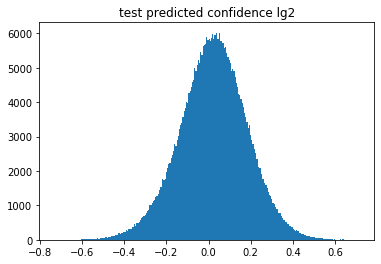

In [0]:
# distribution of confidence that will be used as submission
confidence_test_lgb2= lgb2.predict(X_test)*2 -1
print(accuracy_score(confidence_test_lgb2>0,y_test))
plt.hist(confidence_test_lgb2, bins='auto')
plt.title("test predicted confidence lg2")
plt.show()

In [0]:
# calculation of actual metric that is used to calculate final score
r_test = r_test.clip(-1,1) # get rid of outliers. Where do they come from??
x_t_i = confidence_test_lgb2 * r_test
data = {'day' : d_test, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
std = np.std(x_t)
score_test = mean / std
print(score_test)

0.9092772817952351


# Ensemble lg1 lg2 nn

0.5923590990852791


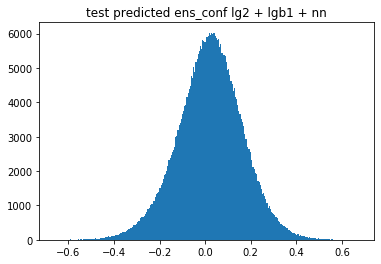

In [0]:
ens_conf = (confidence_test_lgb2 + confidence_test_lgb1)/2
print(accuracy_score(ens_conf>0,y_test))
plt.hist(ens_conf, bins='auto')
plt.title("test predicted ens_conf lg2 + lgb1 + nn")
plt.show()

In [0]:
# calculation of actual metric that is used to calculate final score
r_test = r_test.clip(-1,1) # get rid of outliers. Where do they come from??
x_t_i = ens_conf * r_test
data = {'day' : d_test, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
std = np.std(x_t)
score_test = mean / std
print(score_test)

0.8823358784266261


# Ensemble NN + lgb1 + lgb2

0.5827690039018525


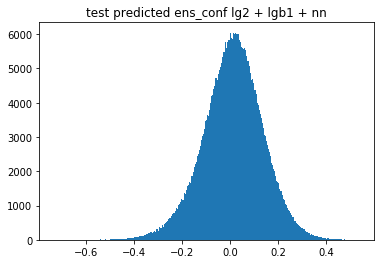

In [0]:
ens_conf_lgb_nn = (confidence_test_lgb2 + confidence_test_lgb1 + confidence_test_nn)/3
print(accuracy_score(ens_conf_lgb_nn>0,y_test))
plt.hist(ens_conf_lgb_nn, bins='auto')
plt.title("test predicted ens_conf lg2 + lgb1 + nn")
plt.show()

In [0]:
# calculation of actual metric that is used to calculate final score
r_test = r_test.clip(-1,1) # get rid of outliers. Where do they come from??
x_t_i = ens_conf_lgb_nn * r_test
data = {'day' : d_test, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
std = np.std(x_t)
score_test = mean / std
print(score_test)

0.7634483521159579
